In [27]:
by = ': Asare Stephen'

Here is some code to read in model-simulated PM2.5 data (in a netCDF file) and compare it to WHO measurements.

Code written by Dr Ben Silver and Dr Carly Reddington.

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np

data_path = './example_data/'

Open measurement data from the WHO Database and extract PM2.5 concentrations (annual mean):

In [4]:
#obs = pd.read_csv(f'{data_path}who_ambient_air_quality_database_version_2023_(v6.0).csv')[['city','year','pm25_concentration','latitude','longitude']]
obs = pd.read_csv(f'{data_path}who_ambient_air_quality_database_version_2023_(v6.0).csv')[['city','year','pm25_concentration','latitude','longitude']]

#select measurements from 2016 only
year = 2016
obs_mean = obs.loc[obs['year']==year]
obs_mean = obs_mean.dropna()

# extract lat lon columns
coords = obs_mean[['latitude', 'longitude']].astype(float)

#drop columns that aren't needed
obs_mean = obs_mean.drop(columns=['year','latitude','longitude']).set_index('city')


Open model data.
Model data is CMIP6 multi-model mean surface PM2.5 concentration averaged over 5 years (2015-2019) for scenario SSP2-4.5:

In [5]:
# use current year from model data (2015-2019 average)
model_mean = xr.open_dataarray(f'{data_path}Annual_mean_surface_PM25_ensemble_mean_CMIP6_5models_ssp245_2015-2019mean_0.125deg.nc')
model_mean = model_mean.drop(labels='time')

#model_mean = xr.open_dataarray(f'{data_path}Merged_annual_mean_surface_PM25_CMIP6_5models_ssp245_GWRPM25_2015-2019mean_0.125deg.nc')

Plot the model data as a global map:

Text(0.5, 1.0, 'Multi-model mean annual mean PM2.5 for 2015-2019')

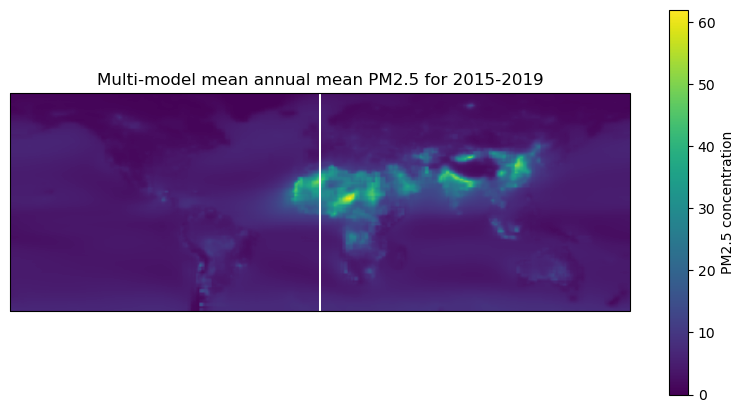

In [26]:
#%% to ensure colour mapping is the same for model and measurements,
# find appropriate limits for both

# take whichever is higher, model/obs 95th quantile
vmax = max(obs_mean['pm25_concentration'].quantile(.95).item(),
           model_mean.quantile(.95).item())

#%% plot figure

latlon_proj = ccrs.Robinson()#ccrs.PlateCarree()

fig = plt.figure(figsize=[10,10])

# add an axis with an orthographic projection
ax = fig.add_subplot(projection=latlon_proj)
# add coastlines
ax.coastlines()
# add borders
ax.add_feature(cf.BORDERS)

# set map extent to match model grid
westlimit=-180.0; southlimit=-50.0; eastlimit=180.0; northlimit=77.0
ax.set_extent([westlimit, eastlimit, southlimit, northlimit],
              crs=latlon_proj) # must tell it coordinates are in latitude longitude


# add model data
model_mean.where(model_mean>0).plot(ax=ax, vmin=0, vmax=vmax, cmap='viridis',
                transform=latlon_proj, # must tell it coordinates are in latitude longitude
                cbar_kwargs={'shrink':.5, 'label':'PM2.5 concentration'},
                zorder=0)

# ax.add_feature(cf.)


ax.set_title('Multi-model mean annual mean PM2.5 for 2015-2019')

Plot the WHO station data on top of the model data, as a global map:

Text(0.5, 1.0, 'Annual mean PM2.5 comparison')

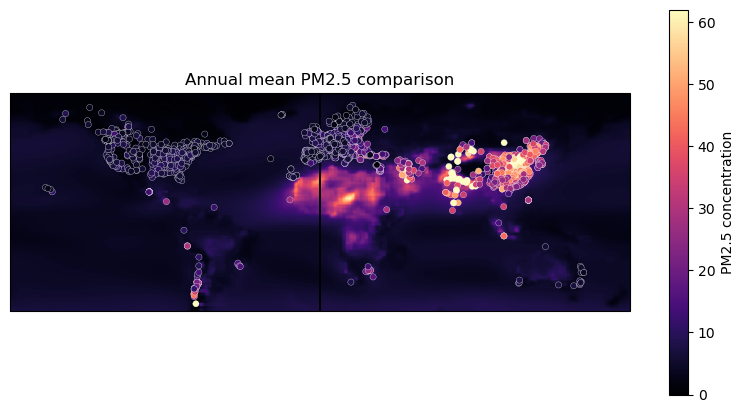

In [8]:
#%% plot figure
fig = plt.figure(figsize=[10,10])

# add an axis with an orthographic projection
ax = fig.add_subplot(projection=latlon_proj)
# add coastlines
ax.coastlines()
# add borders
ax.add_feature(cf.BORDERS)

# set map extent to match model grid
westlimit=-180.0; southlimit=-50.0; eastlimit=180.0; northlimit=77.0
ax.set_extent([westlimit, eastlimit, southlimit, northlimit],
              crs=latlon_proj) # must tell it coordinates are in latitude longitude


# add model data
model_mean.plot(ax=ax, vmin=0, vmax=vmax, cmap='magma',
                transform=latlon_proj, # must tell it coordinates are in latitude longitude
                cbar_kwargs={'shrink':.5, 'label':'PM2.5 concentration'},
                zorder=0)

# add measurement data
ax.scatter(x=coords.longitude, y=coords.latitude, transform=latlon_proj, # must tell it coordinates are in latitude longitude
            c=obs_mean.values, # make colour set by obs value,
            vmin=0, vmax=vmax, cmap='magma', # ensure colourbar is the same
           zorder=1, s=20, edgecolor='white', linewidth=.2)
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.STATES)
ax.set_title('Annual mean PM2.5 comparison')

Plot the modelled and measured PM2.5 concentrations against each other to look at the spatial correlation and model bias:

/tmp/ipykernel_15076/1564629680.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, x, '', color='black', ls='dashed')
/tmp/ipykernel_15076/1564629680.py:20: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, 0.5 * x, '', color='black', ls='dashed')
/tmp/ipykernel_15076/1564629680.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, 2 * x, '', color='black', ls='dashed')


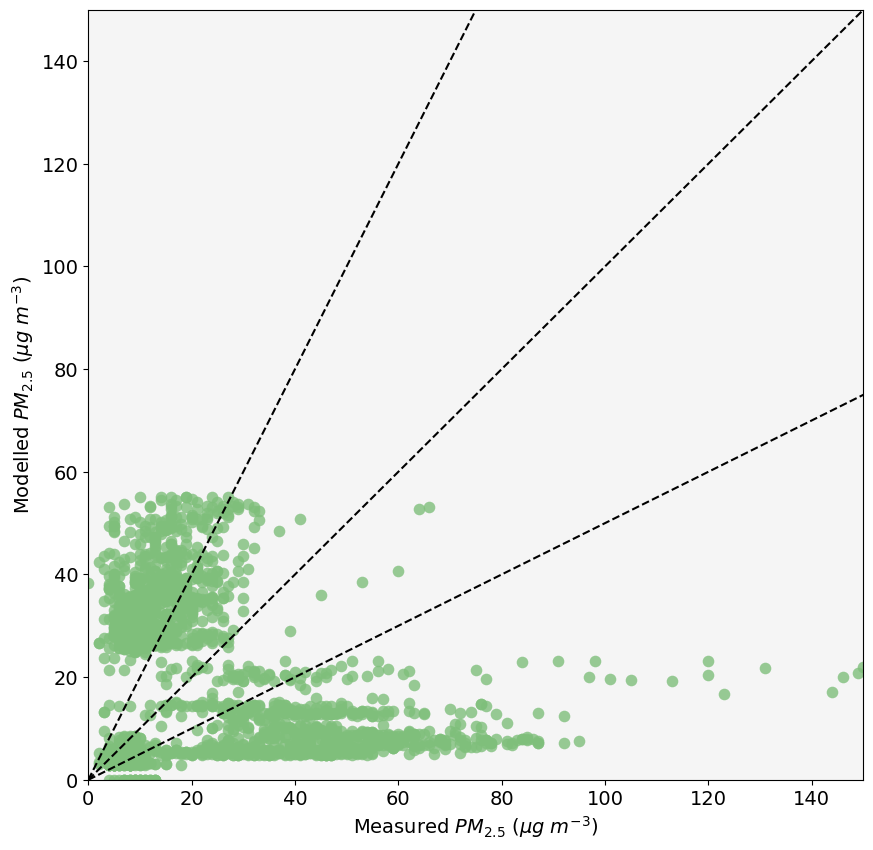

In [9]:

# Get model data at the location of the station
model_station = model_mean.sel(lat=coords.latitude.values,
                               lon=coords.longitude.values, method='nearest').values[0]
obs_station = np.squeeze(obs_mean.values)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot()#gs[0]
ax.set_facecolor('whitesmoke')
plt.ylabel('Modelled $PM_{2.5}$ (${\mu}g$ $m^{-3}$)', fontsize=14)
plt.xlabel('Measured $PM_{2.5}$ (${\mu}g$ $m^{-3}$)', fontsize=14)
vmax = 150
ax.set_xlim((0.0, vmax))
ax.set_ylim((0.0, vmax))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(obs_station, model_station,
            marker='o', lw=0, c='#7fbf7b', s=70, alpha=0.8)
x = np.arange(2 * vmax)
plt.plot(x, x, '', color='black', ls='dashed')
plt.plot(x, 0.5 * x, '', color='black', ls='dashed')
plt.plot(x, 2 * x, '', color='black', ls='dashed')

Calculate a statistical measure of model bias to assess the model performance:

In [10]:
# Calculate the normalised mean bias factor
nmbf=((np.sum(model_station)-np.sum(obs_station))
      /np.absolute(np.sum(model_station)-np.sum(obs_station)))*(np.exp(np.absolute(np.log(np.sum(model_station)/np.sum(obs_station))))-1)

print('NMBF = ',round(nmbf,2))

NMBF =  -0.16
